In [147]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
from Bio import SeqIO
from Bio import Align

import json
import numpy as np
from functools import reduce
from utils import load_patients, load_viruses, compute_virus_alignment_score

# Example with `gap_score`

In [188]:
aligner = Align.PairwiseAligner()
# aligner.open_gap_score = -1
# aligner.extend_gap_score = -1
# aligner.target_end_gap_score = 0.0
# aligner.query_end_gap_score = 0.0

alignments = aligner.align("TATCC", "AC")
for alignment in sorted(alignments):
    print("Score = %.1f:" % alignment.score)
    print(alignment)

alignments.alignment.__dict__

Score = 2.0:
TATCC
-|-|-
-A-C-

Score = 2.0:
TATCC
-|--|
-A--C



{'target': 'TATCC',
 'query': 'AC',
 'score': 2.0,
 'path': ((0, 0), (1, 0), (2, 1), (4, 1), (5, 2))}

# Loading data

In [189]:
viruses_full = load_viruses()
patients_identity_full, patients_entries_full = load_patients()
print(patients_entries_full.shape)
print(patients_identity_full.shape)

viral.3.2.genomic.fna	... Done.
viral.2.3.genomic.fna	... Done.
viral.3.1.genomic.fna	... Done.
viral.2.1.genomic.fna	... Done.
viral.1.1.genomic.fna	... Done.
viral.2.4.genomic.fna	... Done.
viral.2.2.genomic.fna	... Done.
PT8-S2.fastq	... Done.
PT9-S1.fastq	... Done.
PT8-S1.fastq	... Done.
PT7-S1.fastq	... Done.
PT2-S1_1.fastq	... Done.
(310541,)
(310541,)


In [190]:
with open('popular_virus_names.json', 'r') as f:
    popular_viruses_keys = json.load(f)

In [191]:
n_viruses = 87
n_entries = 100

np.random.seed(42)

viruses = {k:viruses_full[k] for k in popular_viruses_keys[:n_viruses]}

random_idx = np.arange(patients_entries_full.shape[0])
np.random.shuffle(random_idx)
random_idx = random_idx[:n_entries]

patients_entries = patients_entries_full[random_idx]
patients_identity = patients_identity_full[random_idx]

In [ ]:
from multiprocessing import Pool

aligner = Align.PairwiseAligner()
aligner.open_gap_score = -1
aligner.extend_gap_score = -1
aligner.target_end_gap_score = 0.0
aligner.query_end_gap_score = 0.0


def comp_al_score(patients_vdna):
    patients_entries, virus_dna = patients_vdna
    return compute_virus_alignment_score(patients_entries, virus_dna, aligner)


tuples_to_process = [(patients_entries, v_dna) for v_dna in viruses.values()]

with Pool(8) as p:
    alignements_scors_list = p.map(
        comp_al_score, 
        tuples_to_process
    )

result = np.array(alignements_scors_list).T

In [159]:
result_copy = result.copy()

In [160]:
result_copy /= result_copy.max(axis=0)

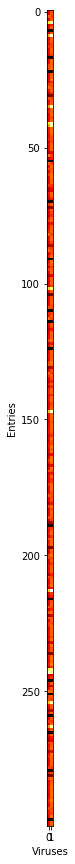

In [161]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 15))
plt.xlabel('Viruses')
plt.ylabel('Entries')
plt.imshow(result_copy, cmap='hot', interpolation='nearest')

In [162]:
patients_results = dict()
for patient_id, entry in zip(patients_identity, result):
    if patient_id not in patients_results:
        patients_results[patient_id] = []
    else:
        patients_results[patient_id] += [entry]

In [163]:
for k in patients_results.keys():
    patients_results[k] = np.array(patients_results[k])

In [164]:
patients_results['PT2-S1_1'].shape

(12, 2)

In [165]:
patients_means_per_virus = dict()
for k in patients_results.keys():
#     patients_means_per_virus[k] = patients_results[k].mean(axis=0)
    patients_means_per_virus[k] = np.median(patients_results[k], axis=0)

In [166]:
patients_means_per_virus['PT2-S1_1'].shape

(2,)

In [167]:
quantiles_label = [0.25, 0.5, 0.75, 1]
virus_quantiles = np.quantile(result, q=quantiles_label, axis=0)

In [168]:
virus_quantiles.shape

(4, 2)

In [184]:
def plot_histograms(virus_to_look, results, patients_identity, viruses):
    result_copy = results.copy()
    
    patients_results = dict()
    for patient_id, entry in zip(patients_identity, result_copy):
        if patient_id not in patients_results:
            patients_results[patient_id] = []
        else:
            patients_results[patient_id] += [entry]
    
    for k in patients_results.keys():
        patients_results[k] = np.array(patients_results[k])
    
    patients_means_per_virus = dict()
    for k in patients_results.keys():
        patients_means_per_virus[k] = np.median(patients_results[k], axis=0)
    
    quantiles_label = [0.25, 0.5, 0.75, 1]
    virus_quantiles = np.quantile(result_copy, q=quantiles_label, axis=0)
    
    # virus_idx = 0
    # virus_to_look = list(viruses.keys())[virus_idx]
    patient_keys = list(patients_means_per_virus.keys())
    patients_points = [patients_means_per_virus[k][virus_idx] for k in patient_keys]
    plt.figure(figsize=(18, 10))
    min_max_x = (-0.05, len(patients_points)-1+0.05)
    min_max_y = (min(patients_points), None)
    
    last_v = 0
    for name, v, c in zip(quantiles_label, virus_quantiles[:, virus_idx], ['green', 'yellow', 'orange', 'red']):
        plt.axhline(y=v, linestyle='--', label=f'{float(name):.2%} quartile', color=c)
        plt.fill_between(x=min_max_x, y1=last_v, y2=v, color=c, alpha=0.6)
        last_v = v
    plt.scatter(x=patient_keys, y=patients_points, s=300, marker='x', c='black')
    for x, (name, y) in enumerate(zip(patient_keys, patients_points)):
        plt.annotate(name, (x+0.05,y))
#     plt.ylim(*min_max_y)
    plt.xlim(*min_max_x)
    plt.title(virus_to_look)
    plt.legend()

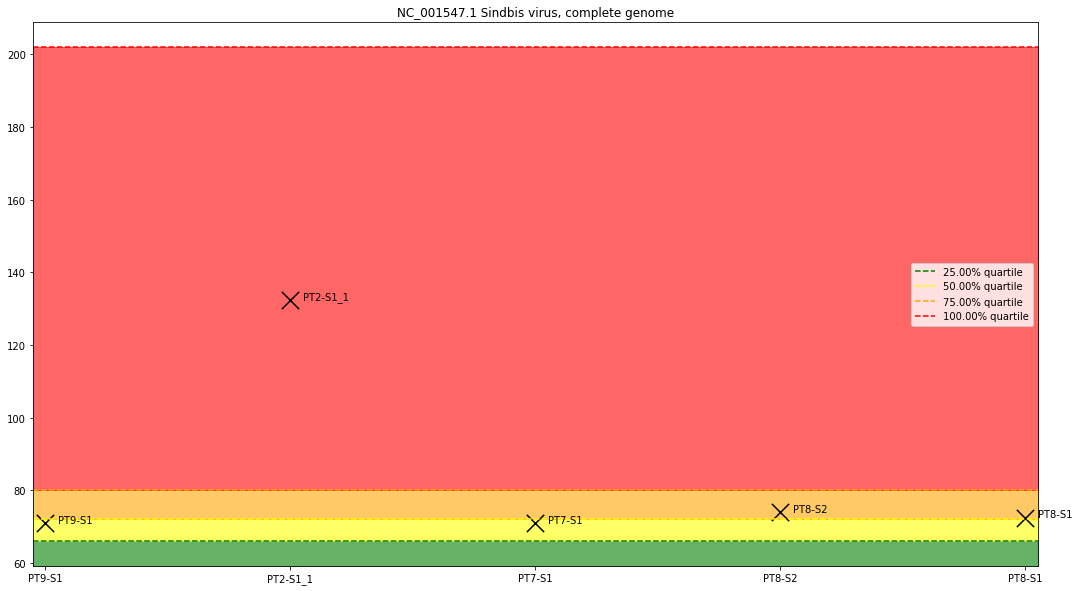

In [185]:
plot_histograms(
    virus_to_look=list(viruses.keys())[1], 
    results=result, 
    patients_identity=patients_identity, 
    viruses=viruses
)

In [107]:
patients_means_per_virus['PT7-S1']

array([67.12280702, 59.87719298, 59.10526316, 62.01754386, 60.12280702,
       63.14035088, 59.21052632, 59.80701754, 59.29824561, 59.12280702,
       64.22807018, 60.71929825, 60.35087719, 60.45614035, 66.28070175,
       59.38596491, 65.75438596, 59.45614035, 60.        , 58.01754386,
       62.87719298, 59.12280702, 59.43859649, 60.87719298, 59.1754386 ,
       61.15789474, 60.19298246, 60.59649123, 59.64912281, 58.85964912,
       58.29824561, 60.07017544, 62.68421053, 60.42105263, 58.8245614 ,
       62.63157895, 59.42105263, 59.12280702, 59.29824561, 58.8245614 ,
       59.        , 58.66666667, 58.40350877, 60.05263158, 58.64912281,
       66.31578947, 60.66666667, 59.56140351, 59.49122807, 60.10526316])

In [172]:
list(viruses.keys())

['NC_001806.2 Human herpesvirus 1 strain 17, complete genome',
 'NC_001547.1 Sindbis virus, complete genome']